In [27]:
#Import all relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
#Load the training dataset
df_train = pd.read_csv('training.csv')
df_train

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62
...,...,...,...,...,...
9995,0,93.61,2074.0,13.08,7.39
9996,1,90.72,1928.0,14.10,6.08
9997,1,94.19,2694.0,0.98,14.95
9998,0,92.65,2176.0,9.28,17.62


In [6]:
#Check to see how many cells are Null
num_rows_with_nan = df_train.isna().any(axis=1).sum()

print(f"The number of rows with Null values is {num_rows_with_nan}.")

The number of rows with Null values is 6.


In [9]:
#Since the number of Null cells is very small compared to the dataset,
#I am going to remove these rows
df_train.dropna(inplace=True)

In [7]:
#Check for oversmapling
counts = df_train['InPlay'].value_counts()
count_zeros = counts[0]
count_ones = counts[1]
count_zeros, count_ones

(7283, 2717)

In [12]:
#Break up data
X = df_train[['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']]
y = df_train['InPlay']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Include feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#Initialize Logistic Regression, Random Forest, SVM, and Gradient Boost models to determine the optimal model
log_reg = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier()
svm = SVC()
gb = GradientBoostingClassifier()

In [19]:
#Evaluate the models
models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'SVM': svm, 'Gradient Boosting': gb}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("__________________________________________________")
    print(f"Classification Report for {name}")
    print(classification_report(y_test, y_pred))
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy for {name}: {accuracy}")
    print("__________________________________________________")

__________________________________________________
Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.77      0.62      0.69      1467
           1       0.32      0.50      0.39       532

    accuracy                           0.59      1999
   macro avg       0.55      0.56      0.54      1999
weighted avg       0.65      0.59      0.61      1999

Accuracy for Logistic Regression: 0.5897948974487244
__________________________________________________
__________________________________________________
Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      1467
           1       0.38      0.07      0.12       532

    accuracy                           0.72      1999
   macro avg       0.56      0.51      0.48      1999
weighted avg       0.65      0.72      0.64      1999

Accuracy for Random Forest: 0.7223611805902952
_______

In [25]:
#Cross Validate the Random Forest Model (Best fitting)
cv_scores = cross_val_score(rf, X, y, cv=5)
print("5-Fold Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Scores:", cv_scores.std())

5-Fold Cross-Validation Scores: [0.71885943 0.71035518 0.71385693 0.70635318 0.70570571]
Mean Cross-Validation Score: 0.7110260836123767
Standard Deviation of Cross-Validation Scores: 0.004898317869524562


In [33]:
#Initialize deploy data
deploy_data = pd.read_csv("deploy.csv")

In [38]:
num_rows_with_nan = deploy_data.isna().any(axis=1).sum()

print(f"The number of rows with Null values is {num_rows_with_nan}.")

The number of rows with Null values is 13.


In [42]:
#As above, since the number of rows with Null values is very small, 
#I am going to remove them
deploy_data.dropna(inplace=True)

In [43]:
deploy_X = deploy_data[['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']]
deploy_X = scaler.transform(deploy_X)

In [44]:
#Save each models prediction for the deployment data
for name, model in models.items():
    deploy_pred = model.predict(deploy_X)
    deploy_data[f'{name}_Predicted'] = deploy_pred

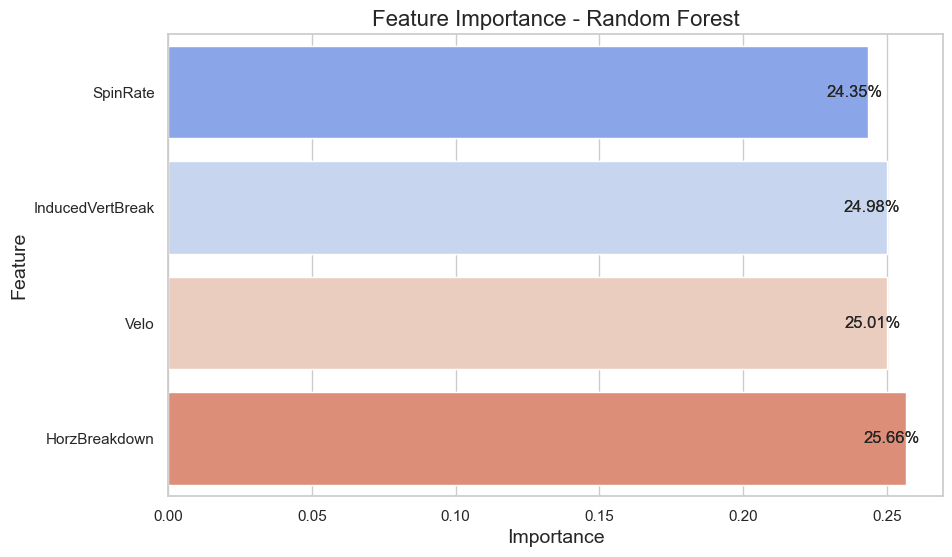

In [32]:
#Feature importance graph for question 2
sns.set(style="whitegrid")

feature_importances = rf.feature_importances_
feature_names = ['Velo', 'SpinRate', 'HorzBreakdown', 'InducedVertBreak']

sorted_idx = feature_importances.argsort()

df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': feature_importances[sorted_idx]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=df, palette='coolwarm')

sns.barplot(x='Importance', y='Feature', data=df, palette='coolwarm')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance - Random Forest', fontsize=16)
for p in ax.patches:
    width = p.get_width()
    ax.text(width - 0.005,p.get_y() + p.get_height() / 2,'{:1.2f}%'.format(width * 100),ha="center",va='center',fontsize=12)
plt.show()